# CS 534: SPRING 2020 : Final Project
## Name : Farhana Alam_114043257
Deadline: 7 May 2020

In [ ]:
# Imports
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, model_selection
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,accuracy_score

from sklearn import svm, datasets
from sklearn.datasets import load_breast_cancer

## Dataset  : (Breast Cancer Wisconsin (Diagnostic) Data Set)
The dataset used in this story is publicly available and was created by Dr. William H. Wolberg, physician at the University Of Wisconsin Hospital at Madison, Wisconsin, USA.The features from the data set describe characteristics of the cell nuclei and are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.Ten real-valued features are computed for each cell nucleus:

* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
*  area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

In [ ]:
#data
data = load_breast_cancer()
dataframe = pd.DataFrame(data.data, columns=[data.feature_names])
dataframe.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Objectives of this Project

The aim of this notebook is to me (and others) to understand the process of organizing and preparing the data, selecting the features, selecting hyper parameters, choosing and applying the machine learning tools, comparing, and improving the models.
Though it is a well known dataset to all, for learning purpuse, **I supposed to work on this project as if know nothing about the dataset. So, I started working with Dimentionality check and Unsupervised methods of machine learning to know about the dataset and then worked with Supervised learning.**

## Dimentionality Check with PCA

In [ ]:
array = dataframe.values

#Unsupervised use
X_u = data.data
y_u = data.target

y_frame = pd.DataFrame(data.target, columns=['class'])

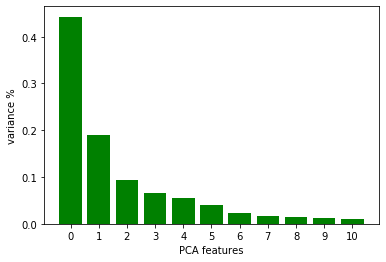

In [ ]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(X_u)

# Create a PCA instance: pca
pca = PCA(n_components=11)
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='green')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

In this step, we are find the optimal number of components which capture the greatest amount of variance in the data. In this case, as seen in plot above, that number is actually one and mostly two. ***The variance drop shows that,the very first component explains the majority of the variance in our data***. For this visualization use case, we will quickly plot just the first two to see if there are any clear clusters.

Text(0, 0.5, 'PCA 2')

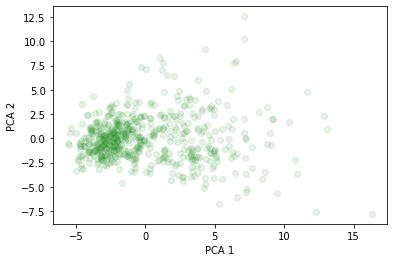

In [ ]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='green')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

The plotting above shows there is mostly one cluster. This factoid tells us that the observations in the dataset is not that much grouped (mostly one). It’s important to note that we do not have a target variable by which to label the groups, so we do not know exactly what these labels are. This plotting does not show us all the meaningful principal components, however, to visualize the rest of the reduced dataset with much greater granularity, we will use k-means clustering.

## Unsupervised Learing
### Elbow Method ( to find best number of clusters)
In order to do this, we will first fit first two principal components to the k-means algorithm and determine the best number of clusters. This process can be done by measuring the sum of the squared distances to the nearest cluster center aka inertia. The k-means screen plot below indicates the percentage of variance explained, which is also the function of the number of clusters.

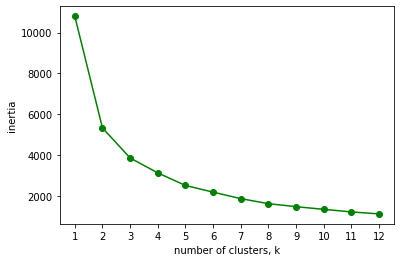

In [ ]:
ks = range(1, 13)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components.iloc[:,:2])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='green')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The Elbow plotting shows that after 2 clusters atthe change in the value of inertia is no longer significant.Therefore we can discard everything after k=2.
### K-means
Let's proced for K-means clustering:

Performance of K-Means = 0.49142453622455523


Text(0, 0.5, 'Feature 1')

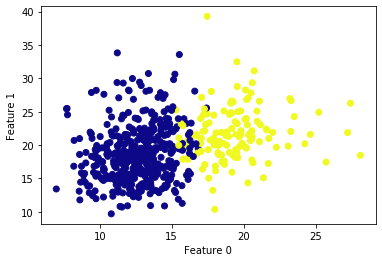

In [ ]:
#k-means
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_u)
y_pred = kmeans.predict(X_u)

print("Performance of K-Means =", adjusted_rand_score(y_u, y_pred))

# plot the cluster assignments and cluster centers
plt.scatter(X_u[:, 0], X_u[:, 1], c=y_pred, cmap="plasma")
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],marker='^', c=[0, 1], linewidth=1,cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

K-means cluster plotting shows two clusters in the dataset but performance is so low. At this point,**we are not that much hopeful about clustering because of all the previous analysis are going against unsupervised clustering**.So, we are skipping to label the clusters. But before totally get off from clustering, let's do DBscan as a last try, as DBScan is more powerful method than K-means.
### DBScan
Let's proced for DBScan and see what result we might have.

Performance of DBSCAN  = 0.0


Text(0, 0.5, 'Feature 1')

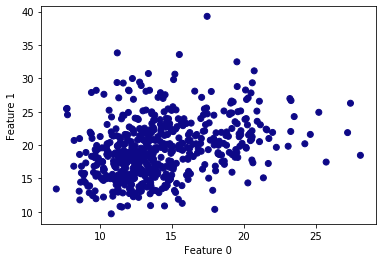

In [ ]:
#DBSCAN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_u)
dbscan = DBSCAN(eps=0.25, min_samples =2)
clusters = dbscan.fit_predict(X_scaled)

print("Performance of DBSCAN  =", adjusted_rand_score(y_u, clusters))

##DBSCAN
plt.scatter(X_u[:, 0], X_u[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

DBScan performance is zero, we better get off from unsupervised to supervised methods.

## Supervised Learning
## Feature selecion
Feature selecion is so important when the number of features are very large. We need to assist our algorithm by feeding in only **those features that are really important.** It is helpful for **avoiding overfitting, training faster as well as easily interpretable.** We are going to use here **Logistic Regression and ExtraTreesClassifier** to determine the important features.

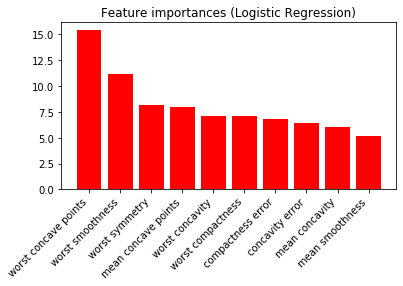

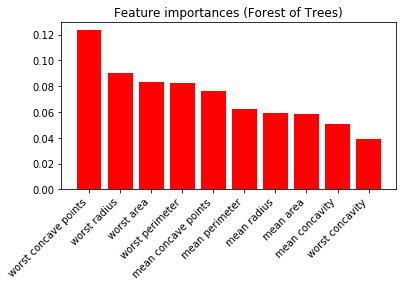

In [ ]:
featuredata = load_breast_cancer()
y = featuredata.target
X = featuredata.data

#Logistic Regression
clf = LogisticRegressionCV(max_iter=3000)
clf.fit(X, y)
coefs = np.abs(clf.coef_[0])
indices = np.argsort(coefs)[::-1]
#Plotting Logistic
plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(10), coefs[indices[:10]],color="r", align="center")
plt.xticks(range(10), data.feature_names[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

# Forest of Trees
clf = ExtraTreesClassifier(n_estimators=400,random_state=0)
clf.fit(X, y)
coefs = clf.feature_importances_
indices = np.argsort(coefs)[::-1]
#Plotting Forest
plt.figure()
plt.title("Feature importances (Forest of Trees)")
plt.bar(range(10), coefs[indices[:10]],color="r", align="center")
plt.xticks(range(10), data.feature_names[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

plt.ion(); plt.show()

Above plottings are showing first ten features for both Logistic Regression and ExtraTreesClassifier and results are not the same. Let's make two datasets for each Feature Selection Classifier only taking first three features. Here,
* df_L would be the dataset containing features **'worst concave points', 'worst smoothness', 'worst symmetry'**; and
* df_F would be the dataset containing features **'worst concave points','worst radius'and 'worst area'**.
#### Datasets after Feature selection

In [ ]:
df_L=dataframe[['worst concave points', 'worst smoothness', 'worst symmetry']]
df_F=dataframe[['worst concave points','worst radius', 'worst area' ]]

df_L = pd.concat([df_L, y_frame], axis=1, sort=False)
df_F = pd.concat([df_F, y_frame], axis=1, sort=False)

df_L.head(), df_F.head()

(   (worst concave points,)  (worst smoothness,)  (worst symmetry,)  class
 0                   0.2654               0.1622             0.4601      0
 1                   0.1860               0.1238             0.2750      0
 2                   0.2430               0.1444             0.3613      0
 3                   0.2575               0.2098             0.6638      0
 4                   0.1625               0.1374             0.2364      0,
    (worst concave points,)  (worst radius,)  (worst area,)  class
 0                   0.2654            25.38         2019.0      0
 1                   0.1860            24.99         1956.0      0
 2                   0.2430            23.57         1709.0      0
 3                   0.2575            14.91          567.7      0
 4                   0.1625            22.54         1575.0      0)

## Support Vector Machine
SVM or Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems and work well for many practical problems. This algorithm creates a line or a hyperplane which separates the data into classes. There are two Important tuning parameters:
* **C:** It controls the trade off between smooth decision boundary and classifying training points correctly. A large value of c means you will get more training points correctly. Large value of C indicates poor accuracy but low bias and vice versa.
* **Gamma:** It defines how far the influence of a single training example reaches. If it has a low value it means that every point has a far reach and conversely high value of gamma means that every point has close reach. High value of gamma gives more accuracy but biased results and vice-versa.

Here we are going to use SVM of different kernels. As, we don't know which SVM Kernel will be suitable for both of our datasets, let's try to have a look on plotting first.

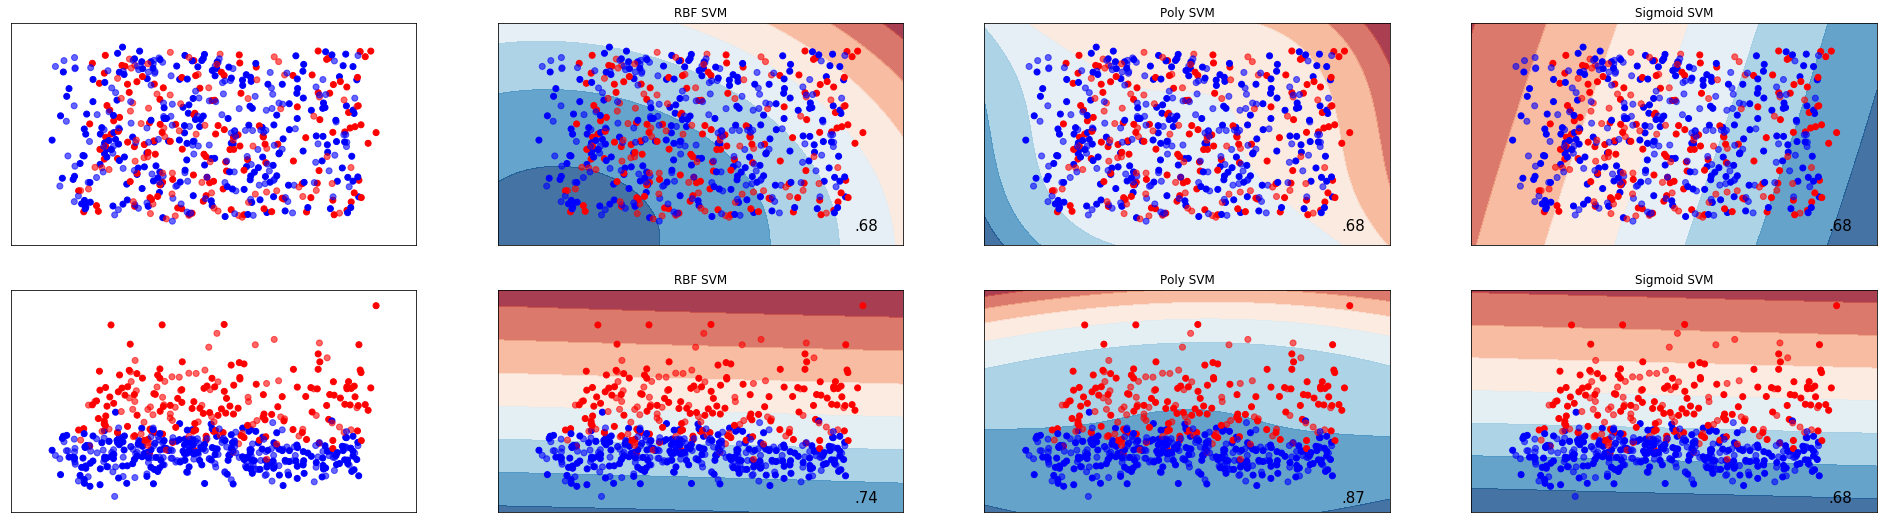

In [ ]:
h = .02  # step size in the mesh

names = ["RBF SVM", "Poly SVM","Sigmoid SVM"]
classifiers = [ SVC(gamma=1e-3, C=1), SVC(kernel="poly", C=1), SVC(kernel="sigmoid", gamma=1e-3)]

#Working with the Dataframe found with Logistic Reg. Features
arrayL = df_L.values
X_L=arrayL[:,0:2]
y = data.target

rng = np.random.RandomState(2)
X_L += 2 * rng.uniform(size=X_L.shape)
dataset_L = (X_L, y)

#Working with the Dataframe found with Forest of trees Features-importance
arrayF = df_F.values
X_F=arrayF[:,0:2]
y = data.target

rng = np.random.RandomState(2)
X_F += 2 * rng.uniform(size=X_F.shape)
dataset_F = (X_F, y)

#Loading dataset array
datasets = [dataset_L, dataset_F]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4,random_state=7)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

Previpus plotting are showing the base data and then RBF kernel, Poly kernel and Sigmoid Kernel for both of the dataframes. But, it is not so understandable which kernel to choose from the plottings. let's try for Grid Search for choosing the best kernel with best parameters.

## Procedure to estimate the best Kernel with the best Parameters
Now we are going to go through a procedure of GridSearch to choose the best kernel(RBF, Polynomial or Sigmoid) with the best tuning parameters (gamma, degree and C).

### Precision vs. Recall
Precision and Recall both indicate accuracy of the model, but in a different way. Each of them has a deeper, distinct meaning. **Precision** means the percentage of the results which are relevant. On the other hand, **Recall** refers to the percentage of total relevant results correctly classified by the algorithm.
**At this moment, we only want to focus on recall for our algorithm. So, we will do the Gridsearch only for Recall.**

## Working on Dataframe(df_L) found with Logistic Regression
### Features : 'worst concave points', 'worst smoothness', 'worst symmetry'
### Best kernel_Best parameters

In [ ]:
#Working with the Dataframe found with Logistic Reg. Features
arrayL = df_L.values
X=arrayL[:,0:2]
y = data.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=7)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'gamma': [1e-3, 1e-4],'degree':[1,3,4,5,7],'C': [1, 10, 100, 1000]}]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s\n" % score)

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:\n")
    print(clf.best_params_)
    print("\nGrid scores on development set:\n")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    print("\nDetailed classification report:\n")
    print("The model is trained on the full development set.\n")
    print("The scores are computed on the full evaluation set.\n")

    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.500 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.891 (+/-0.085) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.500 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.500 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.500 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.500 (+/-0.000) for {'C': 100, 'gamma': 0.0

The GridSearch result says, for Recall, the best hyper-parameters set found on development set is:
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Let's try to plot the dataset applying this GridSearch result.
### Plotting dataset df_L with the best parameters

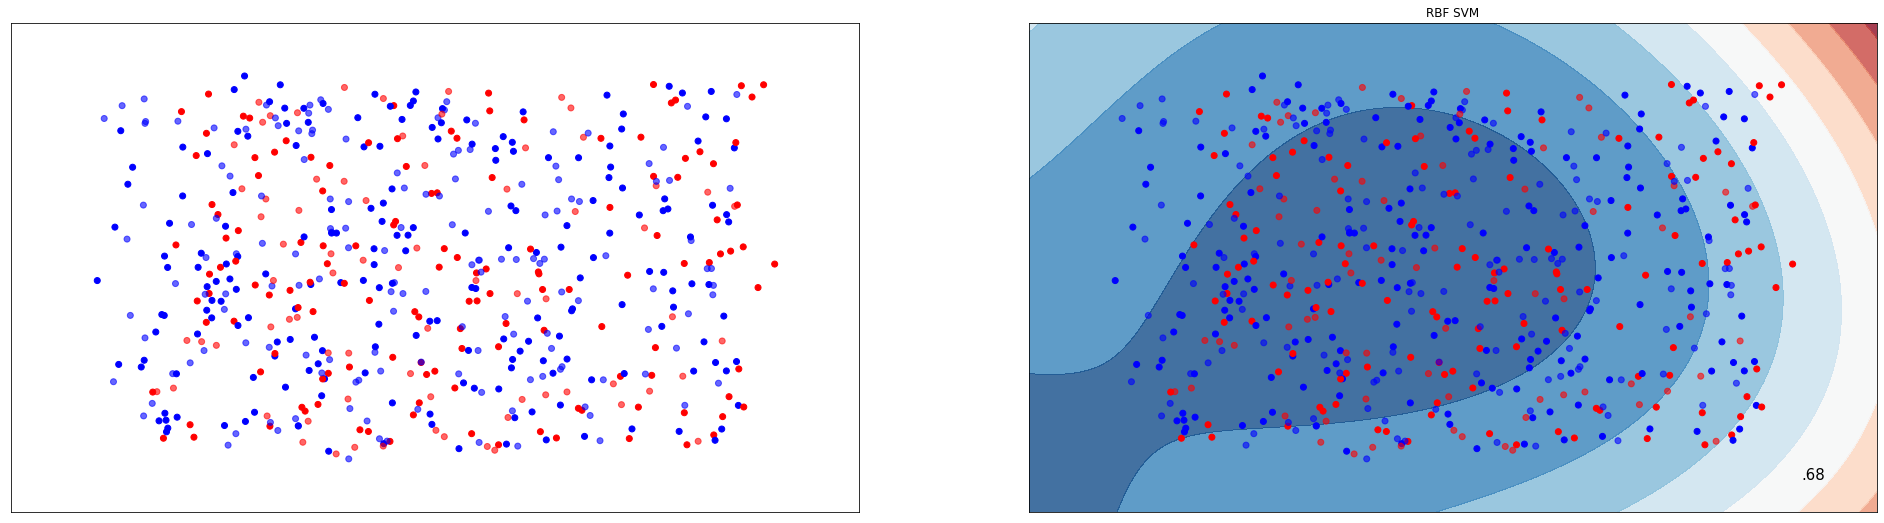

In [ ]:
h = .02  # step size in the mesh

names = ["RBF SVM"]
classifiers = [SVC(gamma=.001, C=1000)]

rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
dataset_L = (X, y)
datasets = [dataset_L]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4,random_state=7)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

### RBF SVM model on the dataset df_L (with the best parameters)
In this stage, we will apply the RBF kerenel with the best parameters on the df_L dataset to see the performance of the model.
###### Model :
In general,the data we use is usually split into training data and test data. The training set contains a known output and the model learns on this data in order to be generalized to other data later on. We have the test dataset (or subset) in order to test our model’s prediction on this subset.

              precision    recall  f1-score   support

           0       1.00      0.18      0.30        96
           1       0.71      1.00      0.83       189

    accuracy                           0.72       285
   macro avg       0.85      0.59      0.56       285
weighted avg       0.80      0.72      0.65       285



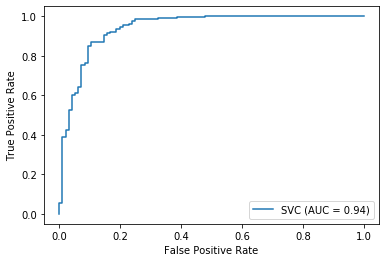

In [ ]:
arrayL = df_L.values
XL=arrayL[:,0:2]
yL = data.target

XL_train, XL_test, yL_train, yL_test = train_test_split( XL, yL, test_size=0.5, random_state=7)

sc = StandardScaler()
XL_train = sc.fit_transform(XL_train)
XL_test = sc.transform(XL_test)

classifier_rbf = SVC(kernel = 'rbf', random_state = 7, gamma=.001)
classifier_rbf.fit(XL_train, yL_train)

yL_pred = classifier_rbf.predict(XL_test)
print(classification_report(yL_test, yL_pred))
rbf_disp = metrics.plot_roc_curve(classifier_rbf,XL_test,yL_test)

### KFold Cross Validation on RBF SVM model for the dataset df_L (with the best parameters)
In this stage, we will apply the RBF kerenel with the best parameters on the df_L dataset to see the performance of the model in each fold created by KFold.

###### K-Folds Cross Validation:
K-Fold is a process which ensures that every observation from the original dataset has the chance of appearing in training and test set. This is one among the best approach if we have a limited input data. This method splits the entire data randomly into k folds where higher value of K leads to less biased model.Then the average of the recorded scores of the foldswill be the performance metric for the model.

In [ ]:
arrayL = df_L.values
X=arrayL[:,0:2]
y = data.target

skf = StratifiedKFold(n_splits=10,random_state=9,shuffle=True)
gamma=.001
acc_train=0
acc_test = 0
splits=10
fo=0
for train_index, test_index in skf.split(X, y):
    print('\nfold=',fo)
    fo+=1
    X_train=X[train_index]
    X_test=X[test_index]
    y_train=y[train_index]
    y_test=y[test_index]

    scaler = StandardScaler()
    XS_train=scaler.fit_transform(X_train)
    XS_test=scaler.transform(X_test)

    XSK_train=rbf_kernel(XS_train, gamma=gamma)
    XSK_test=rbf_kernel(XS_test,XS_train, gamma=gamma)
    clf =svm.LinearSVC(random_state=0, tol=1e-5).fit(XSK_train,y_train)
    ytr_pred=clf.predict(XSK_train)
    y_pred=clf.predict(XSK_test)

    print('Accuracy train', accuracy_score(y_train, ytr_pred))
    acc_train+=accuracy_score(y_train, ytr_pred)
    print('confusion matrix train',confusion_matrix(y_train, ytr_pred))
    print('precision recall fscore support train',precision_recall_fscore_support(y_train, ytr_pred))
    #avgF_train+=precision_recall_fscore_support(y_train, ytr_pred)
    print('\nAccuracy test', accuracy_score(y_test, y_pred))
    acc_test+=accuracy_score(y_test, y_pred)
    print('confusion matrix test',confusion_matrix(y_test, y_pred))
    print('precision recall fscore support test',precision_recall_fscore_support(y_test, y_pred))

acc_train=acc_train/splits
acc_test=acc_test/splits
print('\nTrain accuracy of the model in average: ', acc_train)
print('Test accuracy of the model in average: ', acc_test)


fold= 0
Accuracy train 0.849609375
confusion matrix train [[119  71]
 [  6 316]]
precision recall fscore support train (array([0.952     , 0.81653747]), array([0.62631579, 0.98136646]), array([0.75555556, 0.89139633]), array([190, 322], dtype=int64))

Accuracy test 0.7894736842105263
confusion matrix test [[11 11]
 [ 1 34]]
precision recall fscore support test (array([0.91666667, 0.75555556]), array([0.5       , 0.97142857]), array([0.64705882, 0.85      ]), array([22, 35], dtype=int64))

fold= 1
Accuracy train 0.873046875
confusion matrix train [[149  41]
 [ 24 298]]
precision recall fscore support train (array([0.86127168, 0.87905605]), array([0.78421053, 0.92546584]), array([0.82093664, 0.90166415]), array([190, 322], dtype=int64))

Accuracy test 0.9473684210526315
confusion matrix test [[21  1]
 [ 2 33]]
precision recall fscore support test (array([0.91304348, 0.97058824]), array([0.95454545, 0.94285714]), array([0.93333333, 0.95652174]), array([22, 35], dtype=int64))

fold= 2
Acc

Both Train and Test data is giving good Accuracy scores(in between 73-94%) in each k-fold and bothin average 85%. Probably the reasons are Our gamma is low and C is high which could be a reason for low accuracy. But the accuracy is good which means model is doing pretty good.


## KFold and SVM Kernels comparision
Since we choosed the SVM kernel and the parameters through a GridSearch, we don't know how btter or worse were the other kernels at this fixed parameters. For general interest Let's take a look.

In [ ]:
def LogisticReg(xtrain, xtest, ytrain, ytest):
    logistic = LogisticRegression(random_state=0, solver='lbfgs').fit(xtrain, ytrain)
    ytr_pred=logistic.predict(xtrain)
    y_pred=logistic.predict(xtest)
    print('Train Accuracy Logistic', accuracy_score(ytrain, ytr_pred))
    print('Test Accuracy Logistic', accuracy_score(ytest, y_pred))

def PolyFeatureKernel(xtrain, xtest, ytrain, ytest, degree):
    poly = PolynomialFeatures(degree)
    XSP_train = poly.fit_transform(xtrain)
    XSP_test = poly.fit_transform(xtest)
    #print(XSP_test)
    clf = LogisticRegression(random_state=0, solver='lbfgs').fit(XSP_train,ytrain)
    ytr_pred=clf.predict(XSP_train)
    y_pred=clf.predict(XSP_test)
    print('Train Accuracy PolyFeature', accuracy_score(ytrain, ytr_pred))
    print('Test Accuracy PolyFeature', accuracy_score(ytest, y_pred))

def rbfkernel(xtrain, xtest, ytrain, ytest, gamma):
    XSK_train=rbf_kernel(xtrain, gamma=gamma)
    XSK_test=rbf_kernel(xtest,xtrain, gamma=gamma)
    clf = LogisticRegression(random_state=0, solver='lbfgs').fit(XSK_train,y_train)
    ytr_pred=clf.predict(XSK_train)
    ypred=clf.predict(XSK_test)
    print('Train Accuracy rbf_kernel', accuracy_score(ytrain, ytr_pred))
    print('Test Accuracy rbf_kernel', accuracy_score(ytest, ypred))

def PolyKernel(xtrain, xtest, ytrain, ytest, gamma, degree):
    norm='l2'
    XS_train=preprocessing.normalize(xtrain, norm=norm)
    XS_test=preprocessing.normalize(xtest, norm=norm)
    XSK_train=polynomial_kernel(XS_train, degree=1)
    #print(XSK_train)
    XSK_test=polynomial_kernel(XS_test,XS_train, degree=1)
    clf = LogisticRegression(random_state=0, solver='lbfgs').fit(XSK_train,ytrain)
    ytr_pred=clf.predict(XSK_train)
    y_pred=clf.predict(XSK_test)
    print('Train Accuracy PolyKernel', accuracy_score(ytrain, ytr_pred))
    print('Test Accuracy PolyKernel', accuracy_score(ytest, y_pred))

In [ ]:
arrayL = df_L.values
X=arrayL[:,0:2]
y = data.target

fo=0
gamma = 0.001
degree = 1
skf = StratifiedKFold(n_splits=10,random_state=10,shuffle=True)
for train_index, test_index in skf.split(X, y):
    print('\nfold=',fo)

    fo+=1
    X_train=X[train_index]
    X_test=X[test_index]
    y_train=y[train_index]
    y_test=y[test_index]
    scaler = StandardScaler()
    XS_train=scaler.fit_transform(X_train)
    #print(XS_train.shape)
    XS_test=scaler.fit_transform(X_test)
    LogisticReg(XS_train, XS_test, y_train, y_test)
    PolyFeatureKernel(XS_train, XS_test, y_train, y_test, degree)
    rbfkernel(XS_train, XS_test, y_train, y_test, gamma)
    PolyKernel(XS_train, XS_test, y_train, y_test, gamma, degree)


fold= 0
Train Accuracy Logistic 0.91015625
Test Accuracy Logistic 0.9298245614035088
Train Accuracy PolyFeature 0.91015625
Test Accuracy PolyFeature 0.9298245614035088
Train Accuracy rbf_kernel 0.779296875
Test Accuracy rbf_kernel 0.7719298245614035
Train Accuracy PolyKernel 0.904296875
Test Accuracy PolyKernel 0.8771929824561403

fold= 1
Train Accuracy Logistic 0.90625
Test Accuracy Logistic 0.9122807017543859
Train Accuracy PolyFeature 0.90625
Test Accuracy PolyFeature 0.9122807017543859
Train Accuracy rbf_kernel 0.78515625
Test Accuracy rbf_kernel 0.7368421052631579
Train Accuracy PolyKernel 0.900390625
Test Accuracy PolyKernel 0.8947368421052632

fold= 2
Train Accuracy Logistic 0.908203125
Test Accuracy Logistic 0.9122807017543859
Train Accuracy PolyFeature 0.908203125
Test Accuracy PolyFeature 0.9122807017543859
Train Accuracy rbf_kernel 0.78125
Test Accuracy rbf_kernel 0.8245614035087719
Train Accuracy PolyKernel 0.904296875
Test Accuracy PolyKernel 0.9122807017543859

fold= 3
T

## Working on Dataframe(df_F) found with ExtraTreesClassifier
### Features : 'worst concave points','worst radius', 'worst area'
### Best kernel_Best parameters

In [ ]:
#Working with the Dataframe found with Forest of Trees Features-Importance
arrayF = df_F.values
X=arrayF[:,0:2]
y = data.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=7)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'gamma': [1e-3, 1e-4],'degree':[1,3,4,5,7],'C': [1, 10, 100, 1000]}]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s\n" % score)

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:\n")
    print(clf.best_params_)
    print("\nGrid scores on development set:\n")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    print("\nDetailed classification report:\n")
    print("The model is trained on the full development set.\n")
    print("The scores are computed on the full evaluation set.\n")

    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1000, 'degree': 1, 'gamma': 0.001, 'kernel': 'poly'}

Grid scores on development set:

0.861 (+/-0.051) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.729 (+/-0.061) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.867 (+/-0.049) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.861 (+/-0.051) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.892 (+/-0.091) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.867 (+/-0.049) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.896 (+/-0.064) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.892 (+/-0.091) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.856 (+/-0.058) for {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.526 (+/-0.051) for {'C': 1, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.867 (+/-0.049) for {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.854 (+/-0.059) for {'C': 10, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.887 (+/-0.084) for {'C': 100

The GridSearch result says, for Recall, the best hyper-parameters set found on development set is:
{'C': 1000, 'degree': 1, 'gamma': 0.001, 'kernel': 'poly'}.
Let's try to plot the dataset applying this GridSearch result.
### Plotting dataset df_F with the best parameters

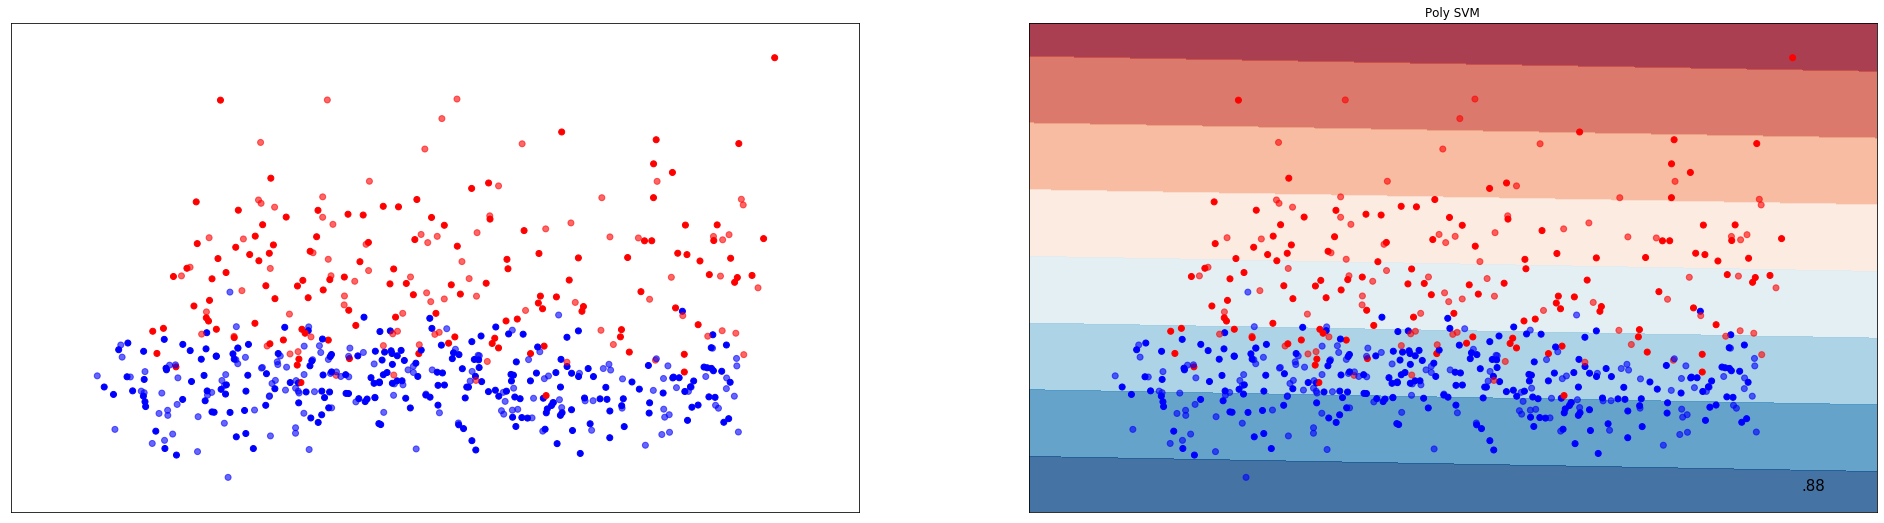

In [ ]:
h = .02  # step size in the mesh

names = [ "Poly SVM"]
classifiers = [SVC(kernel="poly", C=1000, degree=1,gamma=.001)]

rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
dataset_F = (X, y)
datasets = [dataset_F]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4,random_state=9)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()

### RBF SVM model on the dataset df_F (with the best parameters)
In this stage, we will apply the RBF kerenel with the best parameters on the df_F dataset to see the performance of the model.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.66      1.00      0.80       189

    accuracy                           0.66       285
   macro avg       0.33      0.50      0.40       285
weighted avg       0.44      0.66      0.53       285



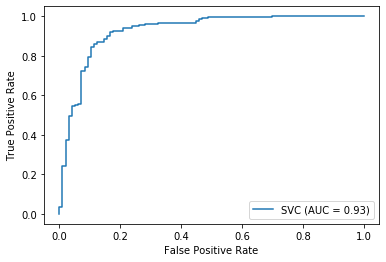

In [ ]:
arrayF = df_F.values
XF=arrayL[:,0:2]
yF = data.target

XF_train, XF_test, yF_train, yF_test = train_test_split( XF, yF, test_size=0.5, random_state=7)

sc = StandardScaler()
XF_train = sc.fit_transform(XF_train)
XF_test = sc.transform(XF_test)

classifier_poly = SVC(kernel = 'poly', random_state = 7, gamma=.001)
classifier_poly.fit(XF_train, yF_train)

yF_pred = classifier_poly.predict(XF_test)

print(classification_report(yF_test, yF_pred))
poly_disp = metrics.plot_roc_curve(classifier_poly,XF_test,yF_test)

### KFold Cross Validation on Polynomial SVM on the dataset df_F (with the best parameters)
In this stage, we will apply the Polynomial kerenel with the best parameters on the df_F dataset to see the performance of the model on in each fold created by KFold.

In [ ]:
arrayF = df_F.values
X=arrayF[:,0:2]
y = data.target

degree=1
gamma = .001
fo=0
norm='l2'
acc_train=0
acc_test = 0
splits=10

for train_index, test_index in skf.split(X, y):
    print('\nfold=',fo)
    fo+=1
    X_train=X[train_index]
    X_test=X[test_index]
    y_train=y[train_index]
    y_test=y[test_index]

    scaler = StandardScaler()
    XS_train=scaler.fit_transform(X_train)
    XS_test=scaler.transform(X_test)

    XS_train=preprocessing.normalize(XS_train, norm=norm)
    XS_test=preprocessing.normalize(XS_test, norm=norm)

    XSK_train=polynomial_kernel(XS_train, degree=degree, gamma = gamma)
    XSK_test=polynomial_kernel(XS_test,XS_train, degree=degree)

    clf = LogisticRegression(random_state=0, solver='lbfgs').fit(XSK_train,y_train)
    ytr_pred=clf.predict(XSK_train)
    y_pred=clf.predict(XSK_test)

    # Train
    print('Accuracy train', accuracy_score(y_train, ytr_pred))
    acc_train+=accuracy_score(y_train, ytr_pred)
    print('confusion matrix train',confusion_matrix(y_train, ytr_pred))
    print('precision recall fscore support train',precision_recall_fscore_support(y_train, ytr_pred))
    #Test
    print('\nAccuracy test', accuracy_score(y_test, y_pred))
    acc_test+=accuracy_score(y_test, y_pred)
    print('confusion matrix',confusion_matrix(y_test, y_pred))
    print('precision recall fscore support test',precision_recall_fscore_support(y_test, y_pred))

acc_train=acc_train/splits
acc_test=acc_test/splits

print('\nTrain accuracy of the model in average: ', acc_train)
print('Test accuracy of the model in average: ', acc_test)


fold= 0
Accuracy train 0.62890625
confusion matrix train [[  0 190]
 [  0 322]]
precision recall fscore support train (array([0.        , 0.62890625]), array([0., 1.]), array([0.        , 0.77218225]), array([190, 322], dtype=int64))

Accuracy test 0.8947368421052632
confusion matrix [[20  2]
 [ 4 31]]
precision recall fscore support test (array([0.83333333, 0.93939394]), array([0.90909091, 0.88571429]), array([0.86956522, 0.91176471]), array([22, 35], dtype=int64))

fold= 1
Accuracy train 0.62890625
confusion matrix train [[  0 190]
 [  0 322]]
precision recall fscore support train (array([0.        , 0.62890625]), array([0., 1.]), array([0.        , 0.77218225]), array([190, 322], dtype=int64))

Accuracy test 0.9824561403508771
confusion matrix [[22  0]
 [ 1 34]]
precision recall fscore support test (array([0.95652174, 1.        ]), array([1.        , 0.97142857]), array([0.97777778, 0.98550725]), array([22, 35], dtype=int64))

fold= 2
Accuracy train 0.626953125
confusion matrix tra

Both Train set is giving a bit lower accuracy (62% in average) but Test set is giving good Accuracy scores 93% in average(in between 89-100% for in each k-fold). So, the model is doing good here too.
## KFold and SVM Kernels comparision
Since we choosed the SVM kernel and the parameters through a GridSearch, we don't know how btter or worse were the other kernels at this fixed parameters. For general interest Let's take a look.

In [ ]:
arrayF = df_F.values
X=arrayF[:,0:2]
y = data.target

fo=0
gamma = 0.001
degree = 1
skf = StratifiedKFold(n_splits=10,random_state=10,shuffle=True)
for train_index, test_index in skf.split(X, y):
    print('\nfold=',fo)

    fo+=1
    X_train=X[train_index]
    X_test=X[test_index]
    y_train=y[train_index]
    y_test=y[test_index]
    scaler = StandardScaler()
    XS_train=scaler.fit_transform(X_train)
    #print(XS_train.shape)
    XS_test=scaler.fit_transform(X_test)
    LogisticReg(XS_train, XS_test, y_train, y_test)
    PolyFeatureKernel(XS_train, XS_test, y_train, y_test, degree)
    rbfkernel(XS_train, XS_test, y_train, y_test, gamma)
    PolyKernel(XS_train, XS_test, y_train, y_test, gamma, degree)


fold= 0
Train Accuracy Logistic 0.947265625
Test Accuracy Logistic 0.9298245614035088
Train Accuracy PolyFeature 0.947265625
Test Accuracy PolyFeature 0.9298245614035088
Train Accuracy rbf_kernel 0.865234375
Test Accuracy rbf_kernel 0.8421052631578947
Train Accuracy PolyKernel 0.951171875
Test Accuracy PolyKernel 0.9298245614035088

fold= 1
Train Accuracy Logistic 0.947265625
Test Accuracy Logistic 0.9824561403508771
Train Accuracy PolyFeature 0.947265625
Test Accuracy PolyFeature 0.9824561403508771
Train Accuracy rbf_kernel 0.869140625
Test Accuracy rbf_kernel 0.8070175438596491
Train Accuracy PolyKernel 0.9453125
Test Accuracy PolyKernel 1.0

fold= 2
Train Accuracy Logistic 0.943359375
Test Accuracy Logistic 0.9824561403508771
Train Accuracy PolyFeature 0.943359375
Test Accuracy PolyFeature 0.9824561403508771
Train Accuracy rbf_kernel 0.869140625
Test Accuracy rbf_kernel 0.8596491228070176
Train Accuracy PolyKernel 0.943359375
Test Accuracy PolyKernel 0.9824561403508771

fold= 3
Tra

We tried to implementing here the feature selection and applying best parameters for both of the algorithms. Though RBF Kernel model is showing a bit better result (accuracy 77%, AUC = 94%) rather than POlynomial kernel model (accuracy 62%, AUC = 93%). So, implementing feature selection and best parameters can helps model a lot to perform sound.